# Rings Analyze Remote
This notebook reads in your model predictions that were generated remotely on scinet, so you can analyze the predictions locally. The option is also available to perform a template match and extract the crater distribution from each image (but takes longer).

In [2]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.template_match_target import *

## Load model and analyze predictions

In [3]:
#location of your predicted images
pred_extension = "models/*_pred.npy"

files = glob.glob(pred_extension)
files

['models/run_moon_convnet_model_FL3_he_normal_pred.npy',
 'models/run_moon_convnet_model_FL3_he_uniform_pred.npy']

In [4]:
#if multiple predictions, choose which one you want to load from the list
model_i=0

data = np.load(files[model_i])
dim = data.shape[1]
print "loaded model predictions: %s"%files[model_i]

loaded model predictions: models/run_moon_convnet_model_FL3_he_normal_pred.npy


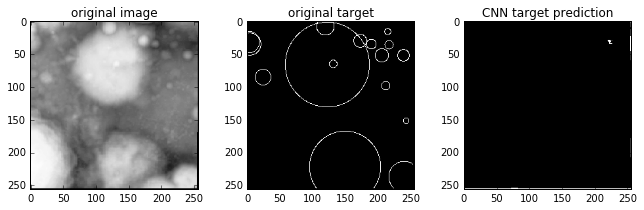

In [6]:
#parameters
img_i=0                #image index you want to run
get_crater_dist = 0    #1 = get crater distribution for img_i. Will take longer.

#analysis and plot
f, ax = plt.subplots(1,3+2*get_crater_dist, figsize=[11+7*get_crater_dist, 3])
ax[0].imshow(data[img_i,:,:,0], origin='upper', cmap="Greys_r")   #original image
ax[1].imshow(data[img_i,:,:,1], origin='upper', cmap="Greys_r")   #original ground truth
ax[2].imshow(data[img_i,:,:,2], origin='upper', cmap="Greys_r")   #predictions
ax[0].set_title('original image')
ax[1].set_title('original target')
ax[2].set_title('CNN target prediction')
#plot circles and make radius distribution
if get_crater_dist == 1:
    coords = template_match_target(data[img_i,:,:,2])
    mask = np.zeros((dim,dim))
    radii_dist = []
    for c in coords:
        x,y,r = c
        cv2.circle(mask, (x,y), r, 1, 1)
        radii_dist.append(r)
    ax[3].imshow(mask, origin='upper', cmap="Greys_r")
    ax[3].set_title('Extracted Circles')
    ax[4].hist(radii_dist, 20)
    ax[4].set_title('Crater Distribution')
    ax[4].set_xlabel('crater radius (pixels)')

#plt.savefig('%s_%d.png'%(os.path.basename(files[model_i]).split('.npy')[0],img_i))

## Plot custom loss vs. epoch

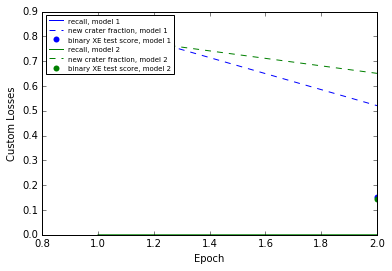

In [22]:
filename = 'output.txt'     #output file from model training

recall, new_craters, N_models = [], [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "mean and std of N_match/N_csv (recall) =" in line:
        recall.append(float(line.split(' = ')[1].split(",")[0]))
    elif "(N_template - N_match)/N_template" in line:
        new_craters.append(float(line.split(' = ')[1].split(",")[0]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(recall)
        p = plt.plot(np.arange(n_epochs)+1, recall, label='recall, model %d'%N_models)
        plt.plot(np.arange(n_epochs)+1, new_craters, linestyle="--", color=p[0].get_color(), label='new crater fraction, model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='binary XE test score, model %d'%N_models)
        plt.legend(loc='upper left',fontsize=7, numpoints=1)
        recall, new_craters = [], []

plt.plot(np.arange(len(epoch_score))+1, epoch_score)
plt.xlabel('Epoch')
plt.ylabel('Custom Losses')

# Plot pixel intensities

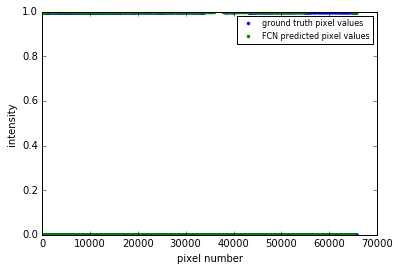

In [15]:
img_i=0
plt.plot(data[img_i,:,:,1].reshape(dim*dim), '.', label='ground truth pixel values')
plt.plot(data[img_i,:,:,2].reshape(dim*dim), '.', label='FCN predicted pixel values')
plt.xlabel('pixel number')
plt.ylabel('intensity')
plt.legend(fontsize=8, numpoints=1)